In [ ]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
csv_file_path = f"{path}/creditcard.csv"
df = pd.read_csv(csv_file_path)
df.head()

Path to dataset files: /kaggle/input/creditcardfraud


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay

In [ ]:
df["Class"].value_counts()

,count
Class,
0,284315
1,492


/tmp/ipython-input-3583629296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


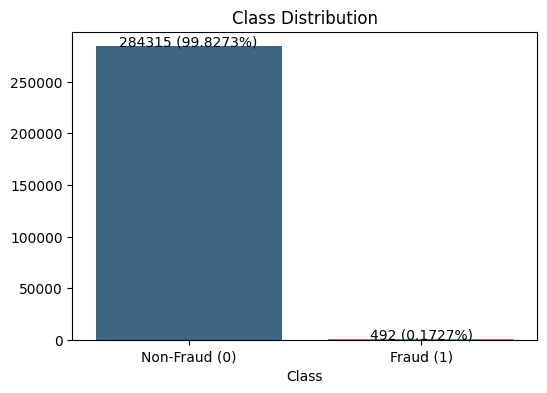

In [ ]:
plt.figure(figsize=(6, 4))
class_counts = df['Class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 200, f'{v} ({v/df.shape[0]*100:.4f}%)', ha='center')
plt.show()

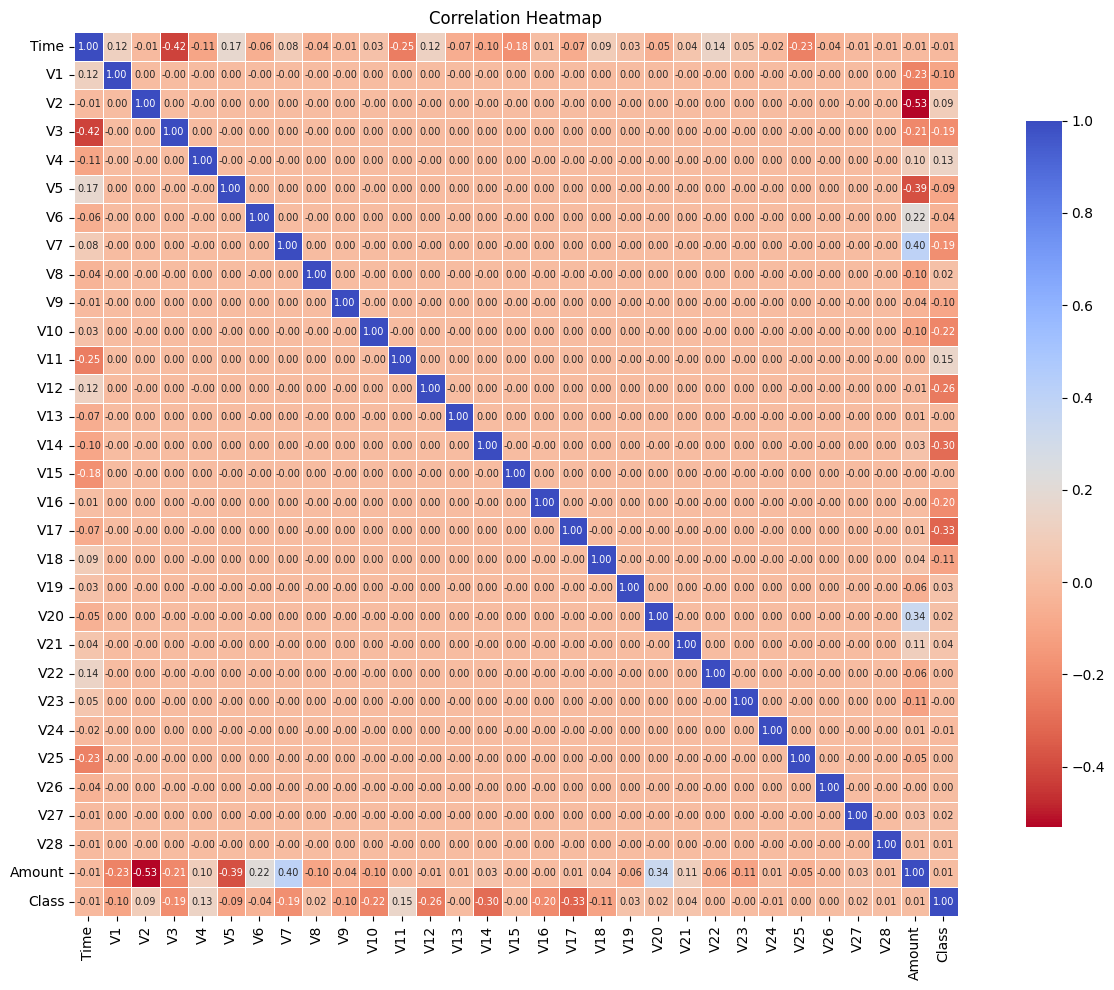

In [ ]:
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 7})  # Reduced font size
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

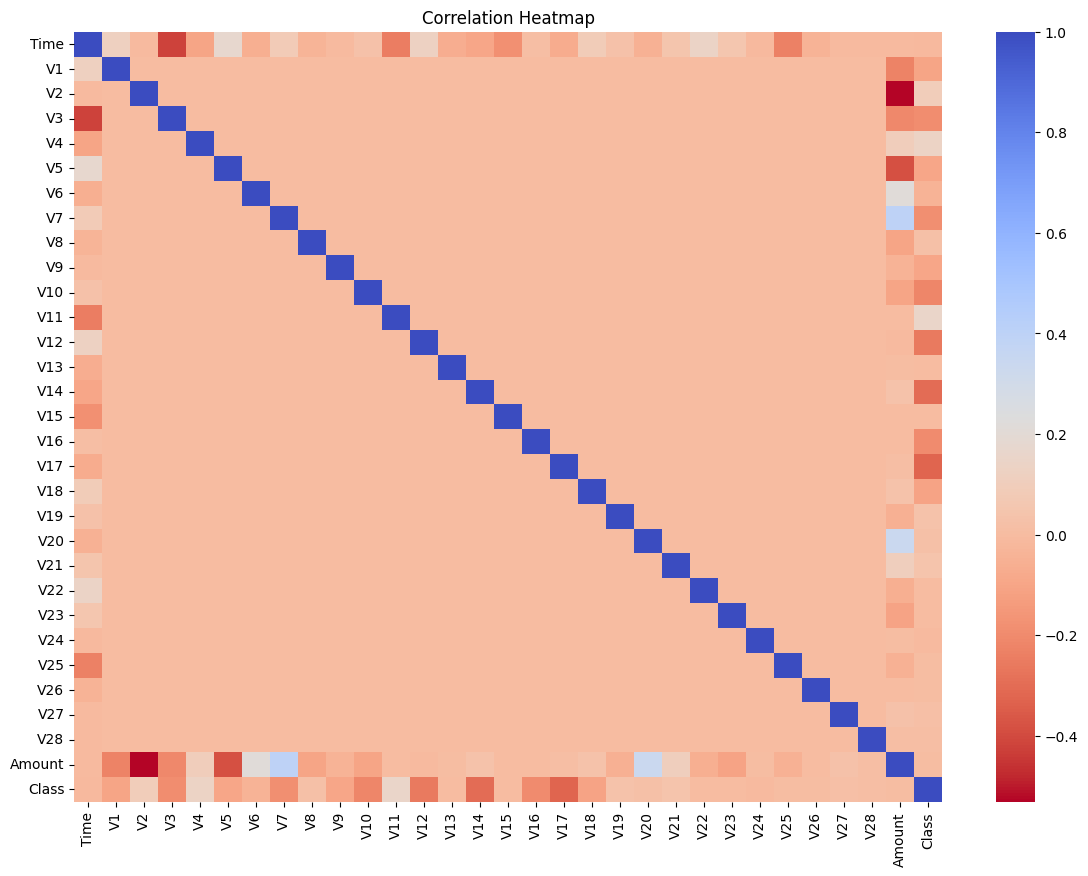

In [ ]:
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=False)
plt.title('Correlation Heatmap')
plt.show()

/tmp/ipython-input-1635747518.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')


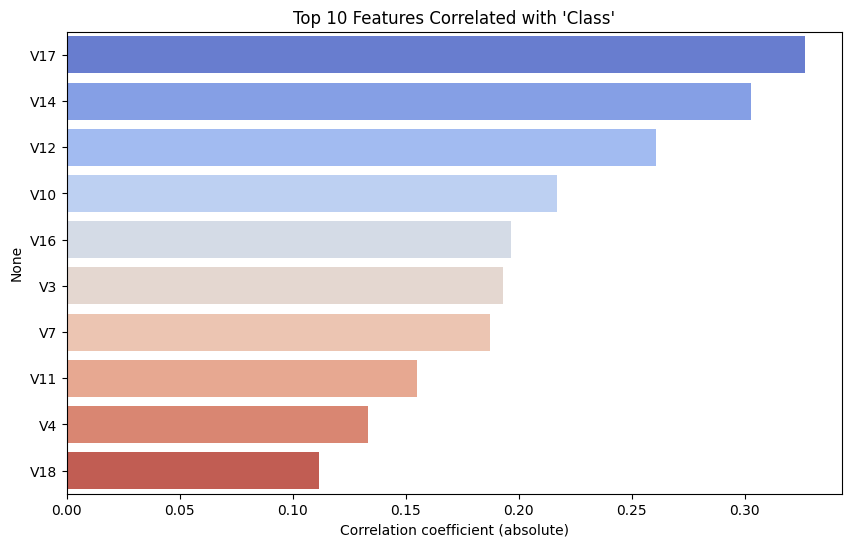

In [ ]:
corr_target = corr['Class'].drop('Class')
top_features = corr_target.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')
plt.title("Top 10 Features Correlated with 'Class'")
plt.xlabel("Correlation coefficient (absolute)")
plt.show()

In [ ]:
df['Hour'] = (df['Time'] // 3600) % 24
df.drop('Time', axis=1, inplace=True)

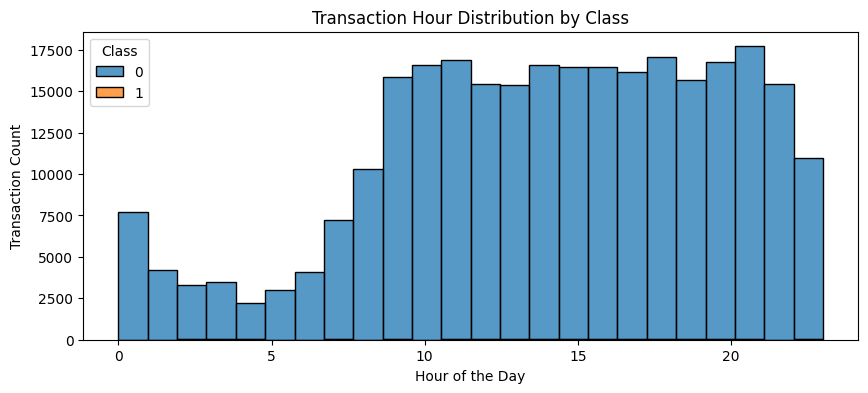

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Hour', hue='Class', bins=24, multiple='stack')
plt.title('Transaction Hour Distribution by Class')
plt.xlabel('Hour of the Day')
plt.ylabel('Transaction Count')
plt.show()

In [ ]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
     "RandomForest": RandomForestClassifier(),
     "SVC": SVC(probability=True),
     "KNeighbors": KNeighborsClassifier(),
     "NaiveBayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
}

In [ ]:
results_untuned = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results_untuned[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "model": model
    }

results_df = pd.DataFrame(results_untuned).T.sort_values(by="accuracy", ascending=False)

print("Model Accuracies (Untuned):\n")
print(results_df[['accuracy']].sort_values(by='accuracy', ascending=False))

best_model_name = results_df.index[0]
print("Best Untuned Model:", best_model_name)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:29:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracies (Untuned):

                    accuracy
RandomForest        0.999473
XGBoost             0.999315
KNeighbors          0.997472
GradientBoosting    0.986921
SVC                  0.98255
NaiveBayes          0.974141
LogisticRegression  0.972087
AdaBoost            0.967698
Best Untuned Model: RandomForest


In [ ]:
models = {"RandomForest": RandomForestClassifier()}

Model Accuracies (Untuned):

              accuracy
RandomForest  0.999421
Best Untuned Model: RandomForest


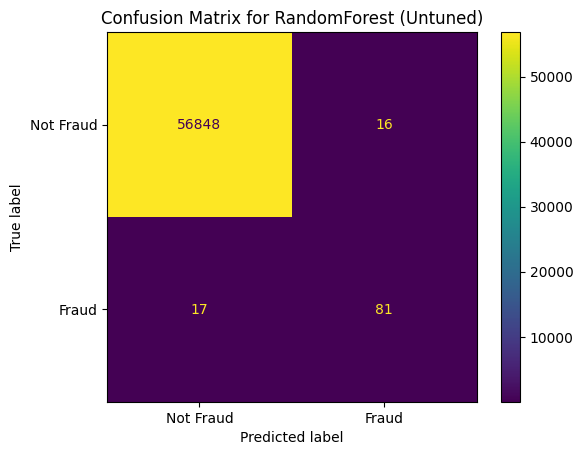

Classification Report for RandomForest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
results_untuned = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results_untuned[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "model": model
    }

results_df = pd.DataFrame(results_untuned).T.sort_values(by="accuracy", ascending=False)

print("Model Accuracies (Untuned):\n")
print(results_df[['accuracy']].sort_values(by='accuracy', ascending=False))

best_model_name = results_df.index[0]
print("Best Untuned Model:", best_model_name)

best_model = results_untuned[best_model_name]["model"]
y_pred_best = results_untuned[best_model_name]["y_pred"]
best_cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot()
plt.title(f'Confusion Matrix for {best_model_name} (Untuned)')
plt.show()

print(f"Classification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred_best))

In [ ]:
# Define parameter grid (same as before)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,             # your RandomForestClassifier
    param_distributions=param_grid,
    n_iter=10,                   # number of random combinations to try
    cv=3,                        # 3-fold cross-validation
    scoring="roc_auc",          # use "f1" or "roc_auc" if imbalanced
    n_jobs=-1,                   # use all CPU cores
    random_state=42,
    verbose=2
)

# Run the search
random_search.fit(X_train, y_train)

# Best results
print("Best Parameters:")
print(random_search.best_params_)
print("\nBest Cross-Validation Score:", random_search.best_score_)

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None}

Best Cross-Validation Score: 0.9799878545243667

Test Accuracy: 0.9995962220427653

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



Accuracy: 0.9995611109160493
Precision: 0.9294117647058824
Recall: 0.8061224489795918
F1 Score: 0.8633879781420765
ROC AUC: 0.9722642926050555

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



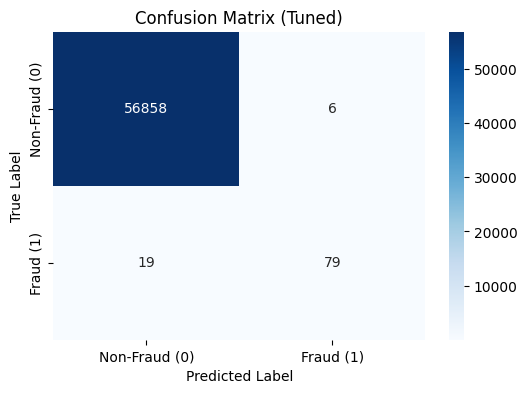

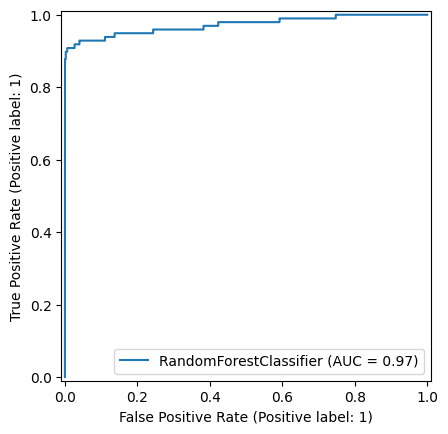

In [ ]:
model = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features="sqrt",
    max_depth=10,
    class_weight=None,
    random_state=42,
    n_jobs=-1
)

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probability for ROC AUC

# --- Evaluation Metrics ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])
plt.title("Confusion Matrix (Tuned)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --- ROC Curve ---
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()